In [82]:
import pandas as pd
import numpy as np
import h5py
import scipy.io as sio
import scipy.signal 
import datetime
from skrebate import SURF
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from skrebate import SURF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import os 
import pickle
import collections

In [41]:
def archive_data(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)
        
def load_file(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
def resample_data(data, num_samps):
    random_samp_idx = sorted(np.random.randint(data.shape[0], size=num_samps))
    return data[random_samp_idx,:]



In [48]:
data_dir = r'C:\Users\hfran\Desktop\FRANCIS\TWH113'
usb_dir = r'E:\OneDrive - University of Toronto\Thesis\pat_FR_1096'
data_lim = 165
#prefix = 'EDMSE_pat_FR_1096_{:03d}.mat'
prefix = 'TWH113_'
filenames = [ os.path.join(data_dir, prefix.format(i)) for i in range(data_lim)]
archive_data_ena = True
sample_data_ena = False

for filename in filenames:
    if not os.path.isfile(filename):
        pass
    else:
        # file downloaded. can open
        f = h5py.File(filename,'r')
        record_idx = int(f['record_idx'].value[0][0])
        sample_sz_onset = f['sample_sz_onset']
        sample_sz_end = f['sample_sz_end']
        sample_scsz_onset = f['sample_scsz_onset']
        sample_scsz_end = f['sample_scsz_end']

        onset_index = int(f[sample_sz_onset.value[0][0]].value[0][0])
        end_index = int(f[sample_sz_end.value[0][0]].value[0][0])
        sc_onset_index = int(f[sample_scsz_onset.value[0][0]].value[0][0])
        sc_end_index = int(f[sample_scsz_end.value[0][0]].value[0][0])
        
        

        #print(sample_sz_onset, sample_sz_end)
        if onset_index != 0 or sc_onset_index != 0:
            print("Record {} Ic: [{}:{}] ({}s) Subclinical: [{}:{}] ({}s)".format(record_idx, onset_index,end_index,(end_index-onset_index)/25,sc_onset_index, sc_end_index,(sc_end_index-sc_onset_index)/25))
                
        if onset_index != 0:
            sz_data = f['se_concat'][:,onset_index:end_index].transpose()
            sz_len = end_index - onset_index
            pre_ictal = f['se_concat'][:, onset_index-8000: end_index-9000].transpose()
            if archive_data_ena: 
                archive_data(sz_data, 'data\\pat_fr_1096_record_{:03d}_sz.pickle'.format(record_idx))
                archive_data(pre_ictal, 'data\\pat_fr_1096_record_{:03d}_presz.pickle'.format(record_idx))
            
        elif sc_onset_index != 0:
            scsz_data = f['se_concat'][:,sc_onset_index:sc_end_index].transpose()
            if sample_data_ena:
                random_samp_idx = sorted(np.random.randint(scsz_data.shape[0], size=256))
                scsz_data = scsz_data[random_samp_idx,:]
            if archive_data_ena: archive_data(scsz_data, 'data\\pat_fr_1096_record_{:03d}_scsz.pickle'.format(record_idx))
        
        f.close()
        continue 
        
        if True: pass
        else: 
            if sample_data_ena:
                print("Record {} Interictal ".format(record_idx))
                all_interictal_data = f['se_concat'][:,:].transpose()
                random_samp_idx = sorted(np.random.randint(all_interictal_data.shape[0], size=500))
                interictal_data = all_interictal_data[random_samp_idx,:]
                if archive_data_ena: archive_data(interictal_data, 'data\\pat_fr_1096_record_{:03d}_inic.pickle'.format(record_idx))

        f.close()

Record 60 Ic: [0:0] (0.0s) Subclinical: [44160:44492] (13.28s)
Record 64 Ic: [0:0] (0.0s) Subclinical: [88371:89267] (35.84s)
Record 66 Ic: [0:0] (0.0s) Subclinical: [29465:30054] (23.56s)
Record 70 Ic: [0:0] (0.0s) Subclinical: [10828:11545] (28.68s)
Record 73 Ic: [79482:82593] (124.44s) Subclinical: [0:0] (0.0s)
Record 80 Ic: [0:0] (0.0s) Subclinical: [7116:7987] (34.84s)
Record 81 Ic: [0:0] (0.0s) Subclinical: [36864:40268] (136.16s)
Record 82 Ic: [0:0] (0.0s) Subclinical: [26214:27110] (35.84s)
Record 85 Ic: [0:0] (0.0s) Subclinical: [79692:80000] (12.32s)
Record 88 Ic: [0:0] (0.0s) Subclinical: [28723:29030] (12.28s)
Record 91 Ic: [0:0] (0.0s) Subclinical: [43904:45081] (47.08s)
Record 93 Ic: [0:0] (0.0s) Subclinical: [10240:10521] (11.24s)
Record 96 Ic: [69586:72599] (120.52s) Subclinical: [0:0] (0.0s)
Record 101 Ic: [15945:19056] (124.44s) Subclinical: [0:0] (0.0s)
Record 120 Ic: [52250:56278] (161.12s) Subclinical: [0:0] (0.0s)
Record 122 Ic: [8294:11440] (125.84s) Subclinical:

In [49]:
def get_data_records():
    '''
    for data stored in pickle format, return record idx and prefixes for all files in folder
    '''
    data_dir = 'data'
    # otherwise directories will get included too 
    onlyfiles = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
    onlyfiles = sorted(onlyfiles, key = lambda x: int(x.split('_')[4]) )
    
    data_records = []
    num_samples = {}
    for file in onlyfiles:
        record_idx = int(file.split('_')[4])

        if '_sz' in file:
            record_type = 'sz'
        elif '_scsz' in file:
            record_type = 'scsz'
        elif '_inic' in file:
            record_type = 'inic'
        elif '_presz' in file:
            record_type = 'presz'
        else:
            record_type = 'unknown'
            print("unknown data type in", file)
        
        dat = (record_idx, record_type, load_file(file))
        if record_type not in num_samples: num_samples[record_type] = 0 
        num_samples[record_type] += dat[2].shape[0]
        data_records.append(dat)
        #(record_idx, record_type, data)
    
    print("ProcessedData: ",num_samples)
    return data_records

all_dat = get_data_records()

ProcessedData:  {'inic': 4000, 'scsz': 2816, 'presz': 17043, 'sz': 25043}


In [104]:
# create datasets for sampling 
'''
Datasets for Training and Testing are created as follows: 
for s in seizures:
    X_train = sorted( ictals + subclinicals + intericitals )
    X_test = s 
    surf ( random sampling of X_train)
    svm.train (X_train)
    result = svm_test(X_test)
    performances.append(result)
'''

def generate_labels(data, loo_seizure):
    # generate labels for dataset, leaving out specified datarecord 
    
    labels = {
        'sz': 1,
        'scsz': 0,
        'presz': 2,
        'inic': 0
    }
    
    X_train = np.vstack([ d[2] for d in data if d[0] != loo_seizure ])
    y_train = np.concatenate([ np.ones(d[2].shape[0]) * labels[d[1]] for d in data if d[0] != loo_seizure ])
    
    X_test = np.vstack([ d[2] for d in data if d[0] == loo_seizure ])
    y_test = np.concatenate([ np.ones(d[2].shape[0]) * labels[d[1]] for d in data if d[0] == loo_seizure ])
    
    return X_train, y_train, X_test, y_test
    

all_ictals = [indx for indx, x in enumerate(all_dat) if x[1] == 'sz' ]
# surfs = []

    
def training_loop(all_dat, all_ictals, cache):
    scores = []
    for s_idx in all_ictals:
        # s = test set 
        s = all_dat[s_idx]

        # construct X_train from remaining seizures, subclinicalictal files, and interictal files 

        # load training data and create labels
        # X_train, y_train = load_data(sorted_list)
        X_train, y_train, X_test, y_test = generate_labels(all_dat, loo_seizure = s[0])
        assert(X_train.shape[0] == y_train.shape[0])
        assert(X_test.shape[0] == y_test.shape[0])
        print("Training Set Size: {}, Test Set Size: {}".format(X_train.shape, X_test.shape))

        # Generate Random Sampling of TrainingData for SURF
        surf_trainx,surf_testx, surf_trainy, surf_testy = train_test_split( X_train, y_train, train_size = 500, random_state = 55)


        surf = SURF(n_features_to_select=250, n_jobs=-1, verbose = True)
        surf.fit(surf_trainx, surf_trainy)

        svm_clf = svm.LinearSVC()
        svm_clf.fit(surf.transform(X_train),y_train)    
        score = svm_clf.score(surf.transform(X_test), y_test)

        scores.append(score)
        cache.append([surf, svm_clf, score])
    print("Training Achieved Score of ", sum(scores)/len(scores))


    

def testing_loop(all_dat, all_ictals, cache):
    # Whittle number of features from 250 to 10 and evaluate average performance 
    avg_scores = []
    for num_features in range(250,10,-25):
        scores = []
        for c_idx, s_idx in enumerate(all_ictals):
            # s = test set 
            s = all_dat[s_idx]

            X_train, y_train, X_test, y_test = generate_labels(all_dat, loo_seizure = s[0])
            assert(X_train.shape[0] == y_train.shape[0])
            assert(X_test.shape[0] == y_test.shape[0])

            # Generate Random Sampling of TrainingData for SURF

            surf = cache[c_idx][0]
            surf.n_features_to_select=num_features 
            
            svm_clf = svm.LinearSVC()
            svm_clf.fit(surf.transform(X_train),y_train)    
            score = svm_clf.score(surf.transform(X_test), y_test)

            scores.append(score)
            
        avg_score = sum(scores)/len(scores)
        avg_scores.append(avg_score)
        print("For {} Features, Average Classification Score of {}".format(num_features, avg_score))
    
    return avg_scores 


    

In [106]:
%%time 
surf_preic_diff = []
training_loop(all_dat, all_ictals, surf_preic_diff)
avg_scores = testing_loop(all_dat,all_ictals,surf_preic_diff)

Training Set Size: (43680, 768), Test Set Size: (5222, 768)


C:\Users\hfran\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Created distance array in 0.2426457405090332 seconds.
Feature scoring under way ...
Completed scoring in 116.55160999298096 seconds.
Training Set Size: (43876, 768), Test Set Size: (5026, 768)
Created distance array in 0.21468639373779297 seconds.
Feature scoring under way ...
Completed scoring in 117.74836945533752 seconds.
Training Set Size: (43680, 768), Test Set Size: (5222, 768)
Created distance array in 0.20703864097595215 seconds.
Feature scoring under way ...
Completed scoring in 115.66888999938965 seconds.
Training Set Size: (41846, 768), Test Set Size: (7056, 768)
Created distance array in 0.20654964447021484 seconds.
Feature scoring under way ...
Completed scoring in 126.04182696342468 seconds.
Training Set Size: (43610, 768), Test Set Size: (5292, 768)
Created distance array in 0.2055211067199707 seconds.
Feature scoring under way ...
Completed scoring in 119.39170742034912 seconds.
Training Set Size: (43744, 768), Test Set Size: (5158, 768)
Created distance array in 0.1905

In [94]:
rankings = collections.defaultdict(float)
for surf in surfs3:
    surf_importances = surf[0].top_features_
    for i,f in enumerate(surf_importances):
        rankings[f] += (len(surf_importances)-i)/len(surf_importances)

        

Text(0.5,1,'Relative Feature Importances for 8 Classifiers')

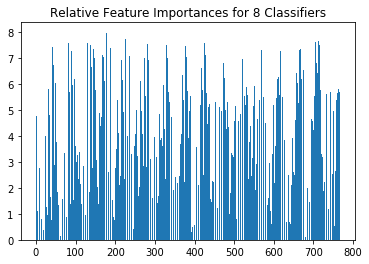

In [96]:
plt.bar(rankings.keys(), rankings.values())
plt.title("Relative Feature Importances for {} Classifiers".format(len(surfs3)))

Text(0.5,0,'Number of Features')

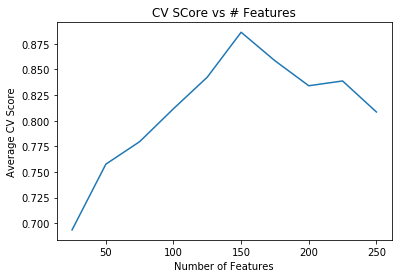

In [99]:
plt.plot(range(250,10,-25), avg_scores)
plt.ylabel("Average CV Score")
plt.title("CV SCore vs # Features")
plt.xlabel("Number of Features")

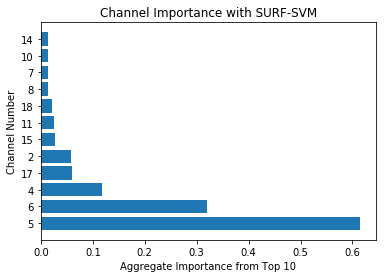

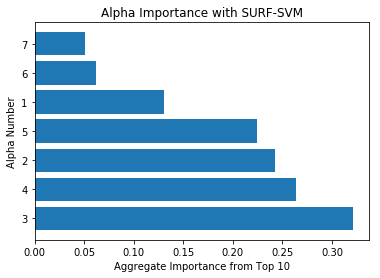

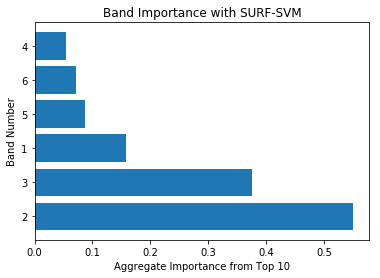

In [135]:
def generate_feature_names(feature_list):
    """ Generating the feature names"""
    if isinstance(feature_list, int):
        n = feature_list
    else:
        n = len(feature_list)
    A, B, C = 1, 1, 1
    features = []
    for i in range(n):
        #features.append(('A{}'.format(A), 'B{}'.format(B), 'C{}'.format(C)))
        features.append([A,B,C])
        A = A + 1 if (A < 7) else 1
        B = B + 1 if (B < 6 and A == 1) else 1 if (A == 1) else B
        C = C + 1 if (B == 1 and A == 1) else C
    return features

def make_barplot(data, label):
    fig = plt.figure()
    t = list(data.items())
    t.sort(key=lambda tup: tup[1], reverse=True)
    k = len(data.items())
    x = [_[0] for _ in t][:k]
    y = [_[1] for _ in t][:k]
    y_pos = np.arange(k)
    plt.barh(y_pos, y[:k])
    plt.yticks(y_pos, x[:k])
    plt.ylabel(label + " Number")
    plt.xlabel("Aggregate Importance from Top 10")
    plt.title(label + " Importance with SURF-SVM")
    

feature_names = generate_feature_names(X_train.shape[1])
alpha_usage = collections.defaultdict(int)
channel_usage = collections.defaultdict(int)
band_usage = collections.defaultdict(int)


features= []
for surf in surfs3:
    top_idx = np.argsort(surf[0].feature_importances_)[-10:]
    for f in top_idx:
        # get the best channel by occrence
        channel_usage[feature_names[f][2]] += surf[0].feature_importances_[f]
        alpha_usage[feature_names[f][0]] += surf[0].feature_importances_[f]
        band_usage[feature_names[f][1]] += surf[0].feature_importances_[f]

        features.append(feature_names[f][2])
        
make_barplot(channel_usage, "Channel")
make_barplot(alpha_usage, "Alpha")
make_barplot(band_usage, "Band")

        
